# Generate missing C-grid coordinates

Climate model output is usually provided with geometric information like the position of the cell center and boundaries. Gridded observational datasets often lack these informations and provide only the position of either
the gridcell center or cell boundary.

This makes the calculation of common vector calculus operators like the
gradient difficult, and results depend on the particular method used.

`xgcm` can infer the cell boundary or cell center location depending on the
geometry of the gridded source dataset. This enables consistent and easily
reproducible calculations across model and observational datasets.

The [autogenerate](api.rst#module-xgcm.autogenerate) module enables the user to apply the same methods to both model output and observational products, which enables better comparison and a unified workflow using different sources of data.

In this case xgcm can infer the missing coordinates to enable the creation of a grid object. Below we will illustrate how to infer coordinates for several example datasets (nonperiodic and periodic) and show how the resulting dataset can be used to perform common calculations like gradients and distance/area weighted averages on observational data.

## Non periodic 1D example: Ocean temperature profile

First let's import xarray and xgcm

In [1]:
import numpy as np
import xarray as xr
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds
import matplotlib.pyplot as plt
%matplotlib inline

Below we will create a synthetic temperature profile with decreasing temperature at depth, with unevenly spaced depth intervals (commonly found in hydrographic data).

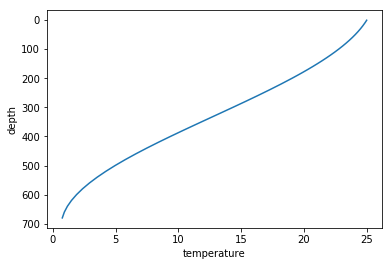

In [2]:
# create a synthetic ocean temperature profile with uneven spacing in depth
z = np.hstack([np.arange(1,10, 1), np.arange(10,200, 10), np.arange(200,700, 20)])
# Create synthetic temperature profile with maximum temperature gradient at mid depth (e.g. the thermocline)
temp = ((np.cos(np.pi*z/700) + 1) + np.exp(-z/350) / 2) * 10

# Convert to xarray.Dataset
ds = xr.DataArray(temp, dims=['depth'], coords={'depth':z}).to_dataset(name='temperature')

ds.temperature.plot(y='depth', yincrease=False)

### Infer the cell boundaries using xgcm.autogenerate
[generate_grid_ds](api.rst#xgcm.autogenerate.generate_grid_ds) can infer the missing cell positions based on the given position (defaults to cell center) and the [axis](grids.rst#axes-and-positions), which is defined by passing a dictionary with the physical axis as key and the dataset dimensions belonging to that axis as values.

In [3]:
# Generate 'full' dataset, which includes additional coordinate `depth_left` and appropriate attributes.
ds_full = generate_grid_ds(ds, {'Z':'depth'})
print(ds_full)
print(ds.depth.data)
print(ds_full.depth_left.data)

<xarray.Dataset>
Dimensions:      (depth: 53, depth_left: 53)
Coordinates:
  * depth        (depth) int64 1 2 3 4 5 6 7 8 9 10 20 30 40 50 60 70 80 90 ...
  * depth_left   (depth_left) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 ...
Data variables:
    temperature  (depth) float64 24.99 24.97 24.96 24.94 24.93 24.91 24.9 ...
[  1   2   3   4   5   6   7   8   9  10  20  30  40  50  60  70  80  90
 100 110 120 130 140 150 160 170 180 190 200 220 240 260 280 300 320 340
 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680]
[5.00e-01 1.50e+00 2.50e+00 3.50e+00 4.50e+00 5.50e+00 6.50e+00 7.50e+00
 8.50e+00 9.50e+00 1.50e+01 2.50e+01 3.50e+01 4.50e+01 5.50e+01 6.50e+01
 7.50e+01 8.50e+01 9.50e+01 1.05e+02 1.15e+02 1.25e+02 1.35e+02 1.45e+02
 1.55e+02 1.65e+02 1.75e+02 1.85e+02 1.95e+02 2.10e+02 2.30e+02 2.50e+02
 2.70e+02 2.90e+02 3.10e+02 3.30e+02 3.50e+02 3.70e+02 3.90e+02 4.10e+02
 4.30e+02 4.50e+02 4.70e+02 4.90e+02 5.10e+02 5.30e+02 5.50e+02 5.70e+02
 5.90e+02 6.10e+02 

We see now that a new dimension `depth_left` was created, with cell boundaries shifted towards the surface

The default behaviour of [generate_grid_ds](api.rst#xgcm.autogenerate.generate_grid_ds) is to extrapolate the grid position to the 'left' (e.g. towards the surface for a depth profile), assuming that the spacing in the two cells closest to the boundary (here: the first and second cell) is equal. Particular geometries might require adjustments of the boundary treatment, by specifying e.g. `pad=0` to ensure the topmost cell boundary is located at the sea surface.

Finally we can create the [xgcm.Grid](api.rst#xgcm.Grid) object like we would from model output (see for example [here](grids.rst#simple-grids)) 

In [4]:
# Create grid object
grid = Grid(ds_full, periodic=False)
print(grid)

<xgcm.Grid>
Z Axis (not periodic):
  * center   depth (53) --> left
  * left     depth_left (53) --> center


### Calculate vertical gradient

Now we have all the tools we need to calculate the vertical gradient just like with numerical model output

In [5]:
# Calculate vertical distances located on the cellboundary
ds_full.coords['dzc'] = grid.diff(ds_full.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds_full.coords['dzt'] = grid.diff(ds_full.depth_left, 'Z', boundary='extrapolate')

<xarray.DataArray (depth_left: 53)>
array([      nan, -0.014527, -0.014688, -0.014849, -0.01501 , -0.015171,
       -0.015332, -0.015493, -0.015655, -0.015816, -0.016706, -0.018326,
       -0.019947, -0.021564, -0.023174, -0.024771, -0.026352, -0.027913,
       -0.029449, -0.030957, -0.032432, -0.033871, -0.03527 , -0.036626,
       -0.037935, -0.039193, -0.040397, -0.041545, -0.042633, -0.044138,
       -0.04592 , -0.047416, -0.04861 , -0.049487, -0.050036, -0.050249,
       -0.050121, -0.049648, -0.048832, -0.047676, -0.046186, -0.044372,
       -0.042245, -0.03982 , -0.037114, -0.034147, -0.030941, -0.027519,
       -0.023908, -0.020134, -0.016226, -0.012214, -0.008129])
Coordinates:
  * depth_left  (depth_left) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 ...
    dzc         (depth_left) int64 1 1 1 1 1 1 1 1 1 1 10 10 10 10 10 10 10 ...


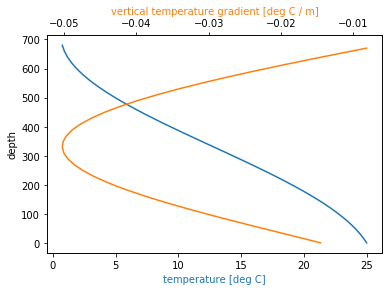

In [6]:
# note that the temperature gradient is located on the `depth_left` dimension, 
# but no temperature information is available, to infer the gradient in the topmost grid cell.
# The following will pad with nan towards the surface. Alternatively the values could be padded with
# with a particular value or linearly extrapolated.

dtemp_dz = grid.diff(ds.temperature, 'Z', boundary='fill', fill_value=np.nan) / ds_full.dzc
print(dtemp_dz)


fig, ax1 = plt.subplots()
ax1.invert_yaxis()
ax2 = ax1.twiny()

ds.temperature.plot(ax=ax1, y='depth', color='C0')
ax1.set_xlabel('temperature [deg C]', color='C0')

dtemp_dz.plot(ax=ax2, y='depth_left', color='C1')
ax2.set_xlabel('vertical temperature gradient [deg C / m]', color='C1');

### Depth weighted average

Another common operation for many climate datasets is a weighted mean along an unevenly spaced dimension. 
Using the grid spacing for the tracer cells earlier this becomes trivial.

In [7]:
mean_temp = ds_full.temperature.mean('depth')
mean_temp_weighted = (ds_full.temperature * ds_full.dzt).sum('depth') / ds_full.dzt.sum('depth')

print(mean_temp.data)
print(mean_temp_weighted.data)

16.271481181388435
12.320585088179214


## Periodic 2D example
Below we will show how to apply these methods similarly to a global surface wind field, which is periodic in the longitudinal ('x') direction.

In [8]:
ds = xr.open_dataset('../datasets/uvwnd.10m.gauss.2018.nc')
ds_full = generate_grid_ds(ds, {'X':'lon', 'Y':'lat'})
ds_full

<xarray.Dataset>
Dimensions:    (lat: 94, lat_left: 94, lon: 192, lon_left: 192, nbnds: 2, time: 71)
Coordinates:
  * lat        (lat) float32 88.542 86.6531 84.7532 82.8508 80.9473 79.0435 ...
  * lon        (lon) float32 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.125 ...
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 2018-01-03 ...
  * lon_left   (lon_left) float32 -0.9375 0.9375 2.8125 4.6875 6.5625 8.4375 ...
  * lat_left   (lat_left) float32 89.48645 87.59755 85.70315 83.802 81.89905 ...
Dimensions without coordinates: nbnds
Data variables:
    uwnd       (time, lat, lon) float32 ...
    time_bnds  (time, nbnds) float64 ...
    vwnd       (time, lat, lon) float32 ...
Attributes:
    Conventions:    COARDS
    title:          mean daily NMC reanalysis (2014)
    history:        created 2017/12 by Hoop (netCDF2.3)
    description:    Data is from NMC initialized reanalysis\n(4x/day).  It co...
    platform:       Model
    References:     http://www.esrl.noaa.gov/psd/data/g

As in the depth profile the longitude and latitude values are extended to the `left` when the defaults are used.
However, since the latitude is not periodic we can specify the position to extend to as `outer` (more details [here](grids.rst#axes-and-positions)). This will extend the latitudinal positions both to the left and right, avoiding missing values later on.

In [9]:
grid = Grid(ds_full, periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic):
  * center   lon (192) --> left
  * left     lon_left (192) --> center
Y Axis (not periodic):
  * center   lat (94) --> left
  * left     lat_left (94) --> center
T Axis (not periodic):
  * center   time (71)

Now we compute the difference (in degrees) along the longitude and latitude for both the cell center and the cell face. Since we are not taking the difference of a data variable across the periodic boundary, we need to specify the `boundary_discontinutity` in order to avoid the introduction of artefacts at the boundary.

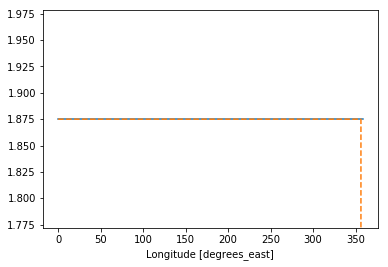

In [10]:
dlong = grid.diff(ds_full.lon, 'X', boundary_discontinuity=360) 
dlonc = grid.diff(ds_full.lon_left, 'X', boundary_discontinuity=360)
dlonc_wo_discontinuity = grid.diff(ds_full.lon_left, 'X')

dlatg = grid.diff(ds_full.lat, 'Y', boundary='fill', fill_value=np.nan)
dlatc = grid.diff(ds_full.lat_left, 'Y', boundary='fill', fill_value=np.nan)

dlonc.plot()
dlonc_wo_discontinuity.plot(linestyle='--')

Without adding the `boundary_discontinuity` input, the last cell distance is calculated incorectly.

The values we just calculated are actually not cell distances, but instead differences in longitude and latitude (in degrees). In order to calculate operators like the gradient `dlon` and `dlat` have to be converted into approximate cartesian distances on a globe.

In [11]:
def dll_dist(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters
   
        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values
   
        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator 
        return dx, dy

ds_full.coords['dxg'], ds_full.coords['dyg'] = dll_dist(dlong, dlatg, ds_full.lon, ds_full.lat)
ds_full.coords['dxc'], ds_full.coords['dyc'] = dll_dist(dlonc, dlatc, ds_full.lon, ds_full.lat)

Based on the distances we can estimate the area of each grid cell and compute the area-weighted meridional average temperature

In [12]:
ds_full.coords['area_c'] = ds_full.dxc * ds_full.dyc

### Compute zonal gradient of the surface wind field
Now that all needed grid metrics are available, we can compute the zonal temperature gradient similar as above.

In [13]:
du_dx = grid.diff(ds_full.uwnd, 'X') / ds_full.dxg
du_dx

<xarray.DataArray (time: 71, lat: 94, lon_left: 192)>
array([[[ 0.000000e+00,  0.000000e+00, ..., -1.180230e-05,  0.000000e+00],
        [ 0.000000e+00,  5.143785e-06, ...,  5.143785e-06,  0.000000e+00],
        ...,
        [ 1.543135e-05,  2.057514e-05, ...,  1.543135e-05,  1.543135e-05],
        [ 4.720920e-05,  3.540689e-05, ...,  3.540689e-05,  4.720920e-05]],

       [[ 0.000000e+00, -1.180230e-05, ..., -2.360460e-05,  0.000000e+00],
        [-5.143785e-06, -5.143785e-06, ..., -5.143785e-06,  0.000000e+00],
        ...,
        [ 1.543135e-05,  1.543135e-05, ...,  1.543135e-05,  1.028757e-05],
        [ 3.540689e-05,  3.540689e-05, ...,  2.360460e-05,  3.540689e-05]],

       ...,

       [[ 0.000000e+00,  1.180230e-05, ...,  1.180230e-05,  1.180230e-05],
        [-5.143785e-06, -1.028757e-05, ..., -5.143785e-06, -5.143785e-06],
        ...,
        [ 2.571892e-05,  2.057514e-05, ...,  2.057514e-05,  2.057514e-05],
        [ 3.540689e-05,  3.540689e-05, ...,  4.720920e-05,  3.540

The values of the gradient are correctly located on the cell boundary on the x-axis and on the cell center in the y-axis

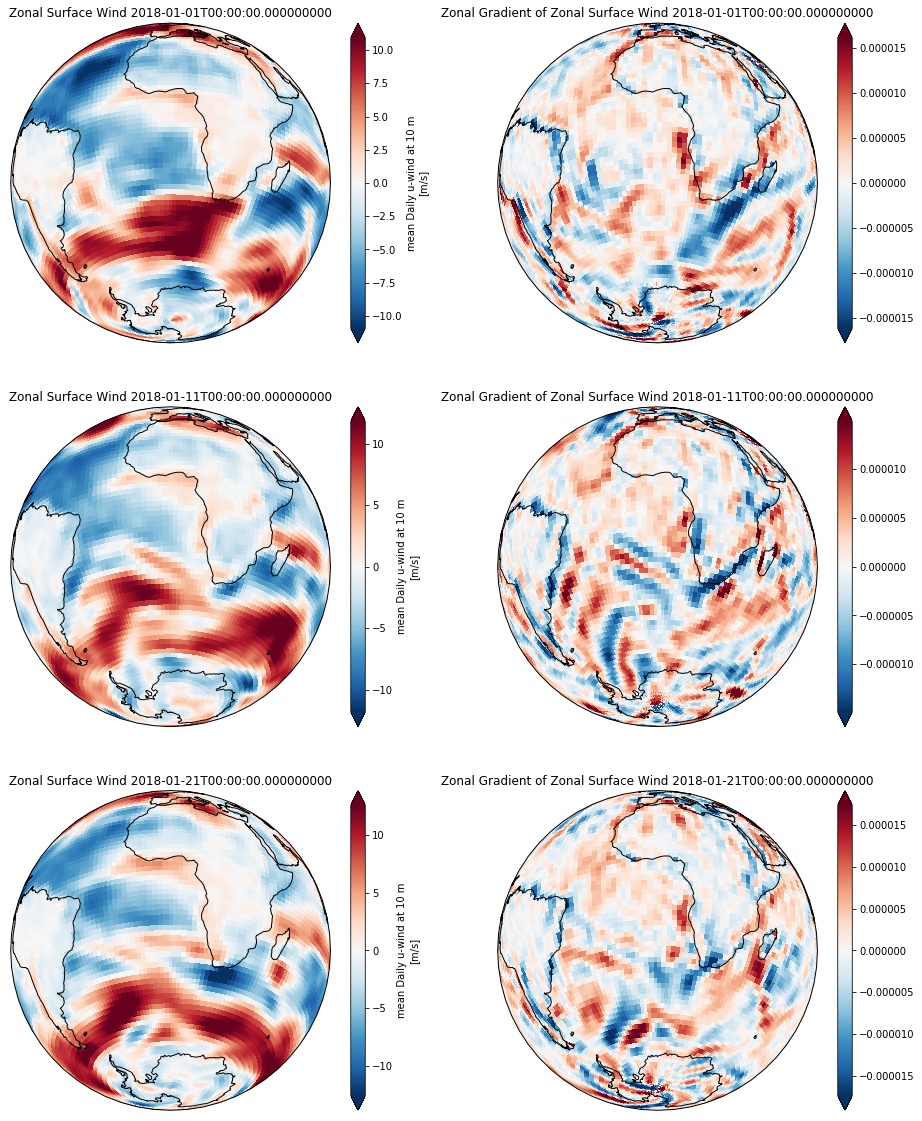

In [14]:
import cartopy.crs as ccrs

fig, axarr = plt.subplots(ncols=2, nrows=3, figsize=[16,20], 
                               subplot_kw=dict(projection=ccrs.Orthographic(0, -30)))

for ti,tt in enumerate(np.arange(0,30, 10)):
    ax1 = axarr[ti,0]
    ax2 = axarr[ti,1]
    time = ds_full.time.isel(time=tt).data
    ds_full.uwnd.isel(time=tt).plot(ax=ax1, transform=ccrs.PlateCarree(),robust=True)

    du_dx.isel(time=tt).plot(ax=ax2, transform=ccrs.PlateCarree(), robust=True)

    ax1.set_title('Zonal Surface Wind %s' %time)
    ax2.set_title('Zonal Gradient of Zonal Surface Wind %s' %time)


    for ax in [ax1, ax2]:
        ax.set_global(); ax.coastlines();

The resulting gradient is correctly computed across the periodic (x-axis) boundary.

### Area weighted average
By using the approximated cell area, we can easily compute the area weighted average of the zonal wind.

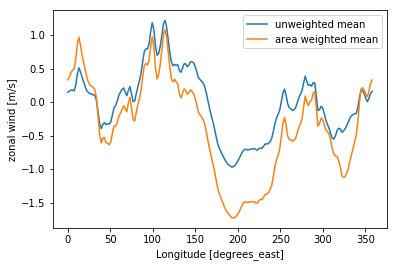

In [19]:
u = ds_full.uwnd.mean('time')

u_mean = u.mean('lat')
u_mean_weighted = (u * u.area_c).sum('lat') / (u.area_c).sum('lat')


u_mean.plot(label='unweighted mean')
u_mean_weighted.plot(label='area weighted mean')
plt.legend()
plt.ylabel('zonal wind [m/s]')
plt.gca().autoscale('tight')

Thes two lines show the importance of applying a weighted mean, when the grid spacing is irregular (e.g. datasets gridded on a regular lat-lon grid).